In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV as GSC
from sklearn.neighbors  import KNeighborsClassifier as KNN
from sklearn import svm

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
########################################################################
#
# Functions for downloading the CIFAR-10 data-set from the internet
# and loading it into memory.
#
# Implemented in Python 3.5
#
# Usage:
# 1) Set the variable data_path with the desired storage path.
# 2) Call maybe_download_and_extract() to download the data-set
#    if it is not already located in the given data_path.
# 3) Call load_class_names() to get an array of the class-names.
# 4) Call load_training_data() and load_test_data() to get
#    the images, class-numbers and one-hot encoded class-labels
#    for the training-set and test-set.
# 5) Use the returned data in your own program.
#
# Format:
# The images for the training- and test-sets are returned as 4-dim numpy
# arrays each with the shape: [image_number, height, width, channel]
# where the individual pixels are floats between 0.0 and 1.0.
#
########################################################################
#
# This file is part of the TensorFlow Tutorials available at:
#
# https://github.com/Hvass-Labs/TensorFlow-Tutorials
#
# Published under the MIT License. See the file LICENSE for details.
#
# Copyright 2016 by Magnus Erik Hvass Pedersen
#
########################################################################

import numpy as np
import pickle
import os
import download
from dataset import one_hot_encoded

########################################################################

# Directory where you want to download and save the data-set.
# Set this before you start calling any of the functions below.
data_path = "D:\cifar10"

# URL for the data-set on the internet.
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

########################################################################
# Various constants for the size of the images.
# Use these constants in your own program.

# Width and height of each image.
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = 10

########################################################################
# Various constants used to allocate arrays of the correct size.

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file

########################################################################
# Private functions for downloading, unpacking and loading data-files.


def _get_file_path(filename=""):
    """
    Return the full path of a data-file for the data-set.

    If filename=="" then return the directory of the files.
    """

    return os.path.join(data_path, "cifar-10-batches-py/", filename)


def _unpickle(filename):
    """
    Unpickle the given file and return the data.

    Note that the appropriate dir-name is prepended the filename.
    """

    # Create full path for the file.
    file_path = _get_file_path(filename)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = pickle.load(file,  encoding='latin1')

    return data


def _convert_images(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


def _load_data(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data['data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data['labels'])

    # Convert the images.
    images = _convert_images(raw_images)

    return images, cls


########################################################################
# Public functions that you may call to download the data-set from
# the internet and load the data into memory.


def maybe_download_and_extract():
    """
    Download and extract the CIFAR-10 data-set if it doesn't already exist
    in data_path (set this variable first to the desired path).
    """

    download.maybe_download_and_extract(url=data_url, download_dir=data_path)


def load_class_names():
    """
    Load the names for the classes in the CIFAR-10 data-set.

    Returns a list with the names. Example: names[3] is the name
    associated with class-number 3.
    """

    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")['label_names']

    # Convert from binary strings.
    return raw


def load_training_data():
    """
    Load all the training-data for the CIFAR-10 data-set.

    The data-set is split into 5 data-files which are merged here.

    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # Begin-index for the current batch.
    begin = 0

    # For each data-file.
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))

        # Number of images in this batch.
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # Store the images into the array.
        images[begin:end, :] = images_batch

        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)


def load_test_data():
    """
    Load all the test-data for the CIFAR-10 data-set.

    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    images, cls = _load_data(filename="test_batch")

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)

########################################################################


In [4]:
m=_get_file_path(filename="batches.meta")
m

'D:\\cifar10\\cifar-10-batches-py/batches.meta'

In [5]:
## load class_names trsining data and testing data
class_names=load_class_names()
images_train, cls_train, labels_train=load_training_data()
images_test,cls_test,labels_test=load_test_data()

Loading data: D:\cifar10\cifar-10-batches-py/batches.meta
Loading data: D:\cifar10\cifar-10-batches-py/data_batch_1
Loading data: D:\cifar10\cifar-10-batches-py/data_batch_2
Loading data: D:\cifar10\cifar-10-batches-py/data_batch_3
Loading data: D:\cifar10\cifar-10-batches-py/data_batch_4
Loading data: D:\cifar10\cifar-10-batches-py/data_batch_5
Loading data: D:\cifar10\cifar-10-batches-py/test_batch


In [6]:
labels_train.shape

(50000, 10)

In [7]:
images_test.shape
images_test=images_test.reshape(10000,3072)
images_test.shape

(10000, 3072)

In [8]:
cls_train.shape
## has values 0 to 9 to which category it is selected
# can be treated as y_traiin
Y_train=cls_train


In [9]:
labels_train.shape

(50000, 10)

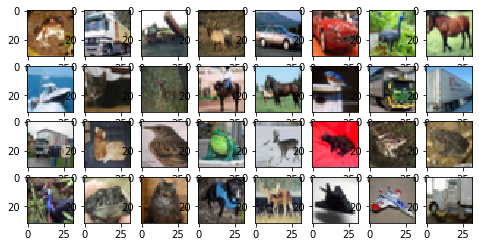

In [10]:
# plotting first 64 images
fig = plt.figure(figsize=(8,8))

for i in range(32):
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(images_train[i],cmap=plt.cm.bone)
plt.show()

In [11]:
images_train.shape

(50000, 32, 32, 3)

In [12]:
images_train

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

In [13]:
yui=images_train.reshape(50000,3072)

In [14]:

yui.shape


(50000, 3072)

In [15]:
pca=PCA()
pca.fit(yui)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [16]:
pca.components_.shape

(3072, 3072)

In [17]:
k=0
tot=sum(pca.explained_variance_)
curr_sum=0
while curr_sum/tot<0.95:
    curr_sum+=pca.explained_variance_[k]
    k+=1
k    

217

REeduce the dimensions from 3072 to 217

In [18]:
pca=PCA(n_components=k)# witen option is false(exlore whether helping or not)
transformed_data=pca.fit_transform(yui)
testing_data=pca.transform(images_test)
transformed_data.shape

(50000, 217)

In [19]:
retrive=pca.inverse_transform(transformed_data)
retrive.shape

(50000, 3072)

In [20]:
retrive_img=retrive.reshape(50000,32,32,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

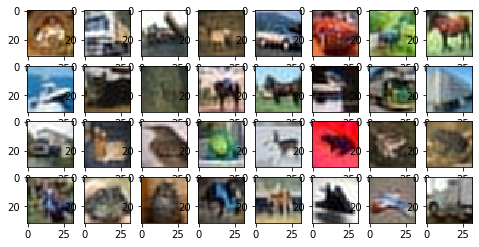

In [21]:
# plotting first 64 images
fig = plt.figure(figsize=(8,8))

for i in range(32):
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(retrive_img[i],cmap=plt.cm.bone)

plt.show()

In [22]:
pca=PCA(n_components=k)
pca.fit(transformed_data)

PCA(copy=True, iterated_power='auto', n_components=217, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

 with several testing due to testing on large dataset taking lots of time 
 run on smaller batch to approximately assume the the best value of C.

In [23]:
clf2=svm.SVC(C=1000,gamma=0.005)
#grid2={'C':[1e2,1e3,5e3,1e4,5e4,1e5],'gamma':[1e-3,5e-4,1e-4,5e-3]}
#abc1=GSC(clf2,grid2)
clf2.fit(transformed_data,Y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [24]:
#clf2.score(x_train,y_train)

In [25]:
#c=1000
#gamma=0.005

In [26]:
#abc1.best_estimator_

In [27]:
#abc1.score(x_test,y_test)

In [28]:
x=clf2.predict(testing_data)

In [29]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [30]:
x

array([3, 8, 8, ..., 5, 5, 7])

In [31]:
cls_test

array([3, 8, 8, ..., 5, 1, 7])

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [36]:
accuracy_score(x,cls_test)
## decent accuracy with SVM's

0.6698

In [41]:
predicton=[]
for i in cls_test:
    predicton.append(class_names[i])
predicton=np.array(predicton)
predicton

array(['cat', 'ship', 'ship', ..., 'dog', 'automobile', 'horse'],
      dtype='<U10')

In [40]:
cls_test

array([3, 8, 8, ..., 5, 1, 7])

In [42]:
np.savetxt('predictons.csv',predicton,fmt='%s')